# Polynomial Fit Method

This notebook is to explore the polynomial fit-based definition of the mean profile from the Castro group. First, let's compare to the box used in the deep_dive notebook. Then if things go well we can explore the globe

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate

In [4]:
import os
os.chdir('/home/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [5]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load Section

In [6]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [7]:
section = ds_p.where((ds_p.LATITUDE < -25) & (ds_p.LATITUDE > -35),drop=True).where((ds_p.LONGITUDE < -138) & (ds_p.LONGITUDE > -140),drop=True).sortby('LATITUDE')

In [8]:
section = section.sortby('N_PROF')

#only keep profiles with at least n data points
ct_counts = section['CT'].count(dim='PRES_INTERPOLATED')
profiles_to_keep = ct_counts >= 500
section_p = section.sel(N_PROF=profiles_to_keep).sortby('LATITUDE')

In [9]:
section_p = section_p.rename({'PRES_INTERPOLATED':'PRESSURE','N_PROF':'PROFILE','LATITUDE':'LAT','LONGITUDE':'LON'})

In [10]:
section_p['SIG1'] = (('PROFILE','PRESSURE'), gsw.density.sigma1(section_p.SA, section_p.CT).values)

In [11]:
nprof = section_p.dims["PROFILE"]
section_p = section_p.assign_coords(NUM=("PROFILE", np.arange(nprof)))

/home/amf2288/miniconda3/envs/Argo_Feb_25/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


## Polynomial fit method to calculate C_m, C_e

In [12]:
def moving_average(arr, window, center=True, mode="reflect"):
    """
    Moving average that returns the same number of points as the input.

    Parameters
    ----------
    arr : array-like (1D)
        Input profile.
    window : int
        Size of the moving window (>=1).
    center : bool, default True
        If True, use a centered window; if False, use a trailing window.
    mode : str, default 'reflect'
        Padding mode passed to np.pad for edge handling. Common options:
        'reflect', 'edge', 'nearest', 'wrap', 'constant'.

    Returns
    -------
    np.ndarray
        Smoothed array with the same length as arr.
    """
    a = np.asarray(arr, dtype=float)
    if a.ndim != 1:
        raise ValueError("moving_average expects a 1D array (profile)")
    if window <= 1:
        return a.copy()

    kernel = np.ones(int(window), dtype=float) / float(window)

    if center:
        left = window // 2
        right = window - 1 - left
    else:
        left = window - 1
        right = 0

    padded = np.pad(a, (left, right), mode=mode)
    out = np.convolve(padded, kernel, mode="valid")
    # out length will be len(a)
    return out

In [13]:
def smooth_profile_1d(sig0, ct, sa, spice, window=5, center=True, mode='reflect', degree=4):
    """
    Smooth a single profile along PRESSURE using polynomial fit and moving average.

    Parameters
    ----------
    sig0, ct, sa, spice : 1D arrays (PRESSURE)
        Inputs for one profile.
    window : int
        Moving average window size.
    center : bool
        Use centered window if True; trailing if False.
    mode : str
        Padding mode for moving_average.
    degree : int
        Polynomial fit degree (default 4).

    Returns
    -------
    ct_out, sa_out, spice_out : 1D arrays (PRESSURE)
        Smoothed values, NaN where input was invalid.
    """
    sig0 = np.asarray(sig0)
    ct   = np.asarray(ct)
    sa   = np.asarray(sa)
    spice= np.asarray(spice)
    n = sig0.size
    ct_out    = np.full(n, np.nan)
    sa_out    = np.full(n, np.nan)
    spice_out = np.full(n, np.nan)
    
    valid_mask = np.isfinite(ct + sig0)
    jj = np.flatnonzero(valid_mask)
    if jj.size < max(window, degree + 1):
        return ct_out, sa_out, spice_out
    
    sig0_valid  = sig0[jj]
    ct_valid    = ct[jj]
    sa_valid    = sa[jj]
    spice_valid = spice[jj]
    
    # Fit polynomials
    p_ct = np.polyfit(sig0_valid, ct_valid, degree)
    p_sa = np.polyfit(sig0_valid, sa_valid, degree)
    p_sp = np.polyfit(sig0_valid, spice_valid, degree)
    pp_ct = np.poly1d(p_ct)
    pp_sa = np.poly1d(p_sa)
    pp_sp = np.poly1d(p_sp)
    
    # Sort by density and smooth
    sort_idx    = np.argsort(sig0_valid)
    sig0_sorted = sig0_valid[sort_idx]
    sig0_smooth = moving_average(sig0_sorted, window, center=center, mode=mode)
    
    # Check if smoothed density is still monotonic
    if len(sig0_smooth) != len(sig0_sorted):
        # Length mismatch after moving average
        return ct_out, sa_out, spice_out
    
    # Ensure strict monotonicity by adding tiny increments where needed
    diffs = np.diff(sig0_smooth)
    if np.any(diffs <= 0):
        # Make strictly increasing by adding small epsilon
        for i in range(len(diffs)):
            if diffs[i] <= 0:
                sig0_smooth[i+1] = sig0_smooth[i] + 1e-10
    
    # Evaluate at smoothed density and interpolate back to original valid points
    ct_smooth    = pp_ct(sig0_smooth)
    sa_smooth    = pp_sa(sig0_smooth)
    spice_smooth = pp_sp(sig0_smooth)
    
    try:
        f_ct    = interpolate.PchipInterpolator(sig0_smooth, ct_smooth, extrapolate=False)
        f_sa    = interpolate.PchipInterpolator(sig0_smooth, sa_smooth, extrapolate=False)
        f_spice = interpolate.PchipInterpolator(sig0_smooth, spice_smooth, extrapolate=False)
        ct_out[jj]    = f_ct(sig0_valid)
        sa_out[jj]    = f_sa(sig0_valid)
        spice_out[jj] = f_spice(sig0_valid)
    except (ValueError, RuntimeError) as e:
        # Leave NaNs if interpolation fails
        pass
    
    return ct_out, sa_out, spice_out

In [23]:
def smooth_profiles_apply_ufunc(section_p, sig_var='SIG0', window=5, center=True, mode='reflect', degree=4, use_dask=True, chunk_size=32, progress=True):
    """
    Parallel smoothing across PROFILE using xarray.apply_ufunc.

    Returns a new Dataset with CT_m, SA_m, SPICE_m.
    Shows a dask ProgressBar when dask is available; otherwise falls back to a tqdm loop.
    """
    import xarray as xr
    ds = section_p
    # Ensure expected dims
    if not {'PROFILE','PRESSURE'}.issubset(ds.dims):
        raise ValueError("section_p must have dims ('PROFILE','PRESSURE')")
    
    # Try dask path
    use_dask_path = False
    if use_dask:
        try:
            import dask  # noqa: F401
            from dask.diagnostics import ProgressBar
            use_dask_path = True
        except Exception:
            use_dask_path = False
    
    if use_dask_path:
        ds_chunked = ds.chunk({'PROFILE': chunk_size})
        def _func(s, c, a, p):
            return smooth_profile_1d(s, c, a, p, window=window, center=center, mode=mode, degree=degree)
        ct_da, sa_da, spice_da = xr.apply_ufunc(
            _func,
            ds_chunked[sig_var], ds_chunked['CT'], ds_chunked['SA'], ds_chunked['SPICE'],
            input_core_dims=[['PRESSURE'], ['PRESSURE'], ['PRESSURE'], ['PRESSURE']],
            output_core_dims=[['PRESSURE'], ['PRESSURE'], ['PRESSURE']],
            vectorize=True,
            dask='parallelized',
            output_dtypes=[float, float, float]
        )
        # Ensure dimension order
        ct_da    = ct_da.transpose('PROFILE','PRESSURE')
        sa_da    = sa_da.transpose('PROFILE','PRESSURE')
        spice_da = spice_da.transpose('PROFILE','PRESSURE')
        if progress:
            with ProgressBar():
                ct_da    = ct_da.compute()
                sa_da    = sa_da.compute()
                spice_da = spice_da.compute()
        ds_out = ds.copy()
        ds_out['CT_m']    = ct_da
        ds_out['SA_m']    = sa_da
        ds_out['SPICE_m'] = spice_da
        
        ds_out['CT_e']    = ds_out['CT'] - ds_out['CT_m']
        ds_out['SA_e']    = ds_out['SA'] - ds_out['SA_m']
        ds_out['SPICE_e'] = ds_out['SPICE'] - ds_out['SPICE_m']
        return ds_out
    else:
        # Fallback: tqdm over profiles without dask
        from tqdm.auto import tqdm
        nprof = ds.dims['PROFILE']
        npres = ds.dims['PRESSURE']
        CT_m    = np.full((nprof, npres), np.nan)
        SA_m    = np.full((nprof, npres), np.nan)
        SPICE_m = np.full((nprof, npres), np.nan)
        for i in tqdm(range(nprof), desc='Smoothing profiles', disable=not progress):
            prof = ds.isel(PROFILE=i)
            ct_out, sa_out, spice_out = smooth_profile_1d(
                prof[sig_var].values, prof['CT'].values, prof['SA'].values, prof['SPICE'].values,
                window=window, center=center, mode=mode, degree=degree
            )
            CT_m[i, :]    = ct_out
            SA_m[i, :]    = sa_out
            SPICE_m[i, :] = spice_out
        ds_out = ds.copy()
        ds_out['CT_m']    = (('PROFILE','PRESSURE'), CT_m)
        ds_out['SA_m']    = (('PROFILE','PRESSURE'), SA_m)
        ds_out['SPICE_m'] = (('PROFILE','PRESSURE'), SPICE_m)

        ds_out['CT_e'] = (('PROFILE','PRESSURE'), ds_out['CT'] - ds_out['CT_m'])
        ds_out['SA_e'] = (('PROFILE','PRESSURE'), ds_out['SA'] - ds_out['SA_m'])
        ds_out['SPICE_e'] = (('PROFILE','PRESSURE'), ds_out['SPICE'] - ds_out['SPICE_m'])
        return ds_out

In [28]:
section_3 = smooth_profiles_apply_ufunc(section_p, 'SIG1', window=10, center=True, mode='reflect', degree=3, use_dask=True, chunk_size=32, progress=True)
section_4 = smooth_profiles_apply_ufunc(section_p, 'SIG1', window=10, center=True, mode='reflect', degree=4, use_dask=True, chunk_size=32, progress=True)
section_5 = smooth_profiles_apply_ufunc(section_p, 'SIG1', window=10, center=True, mode='reflect', degree=5, use_dask=True, chunk_size=32, progress=True)
section_6 = smooth_profiles_apply_ufunc(section_p, 'SIG1', window=10, center=True, mode='reflect', degree=6, use_dask=True, chunk_size=32, progress=True)

[########################################] | 100% Completed | 4.30 sms
[########################################] | 100% Completed | 4.46 sms
[########################################] | 100% Completed | 4.46 sms
[########################################] | 100% Completed | 4.40 sms
[########################################] | 100% Completed | 4.04 sms
[########################################] | 100% Completed | 4.19 sms
[########################################] | 100% Completed | 4.38 sms
[########################################] | 100% Completed | 4.15 sms
[########################################] | 100% Completed | 4.23 sms
[#####                                   ] | 12% Completed | 2.76 s ms

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)


[########################################] | 100% Completed | 4.42 s
[#####                                   ] | 12% Completed | 2.80 s ms

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)


[########################################] | 100% Completed | 4.33 s
[#####                                   ] | 12% Completed | 2.74 s ms

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)


[########################################] | 100% Completed | 4.27 s


In [51]:
section_p.sel(PRESSURE=slice(375,1850))

<xarray.Dataset>
Dimensions:          (PROFILE: 409, PRESSURE: 738)
Coordinates:
  * PRESSURE         (PRESSURE) int64 376 378 380 382 ... 1844 1846 1848 1850
  * PROFILE          (PROFILE) int64 1983300 1983280 1984183 ... 1264653 1263963
    TIME             (PROFILE) datetime64[ns] 2018-03-28T01:11:23 ... 2017-09...
    LAT              (PROFILE) float64 -34.9 -34.88 -34.81 ... -25.3 -25.1 -25.1
    LON              (PROFILE) float64 -138.6 -138.7 -138.5 ... -139.6 -139.4
    NUM              (PROFILE) int64 0 1 2 3 4 5 6 ... 403 404 405 406 407 408
Data variables: (12/17)
    CT               (PROFILE, PRESSURE) float64 7.979 7.965 ... 2.094 2.093
    CYCLE_NUMBER     (PROFILE, PRESSURE) float64 95.0 95.0 95.0 ... 76.0 76.0
    PLATFORM_NUMBER  (PROFILE, PRESSURE) float64 5.902e+06 ... 5.902e+06
    PRES             (PROFILE, PRESSURE) float32 376.0 378.0 ... 1.85e+03
    PSAL             (PROFILE, PRESSURE) float32 34.43 34.43 ... 34.62 34.62
    SA               (PROFILE, PRESSURE) float64 34.59 34.59 ... 34.79 34.79
    ...               ...
    CT_m             (PROFILE, PRESSURE) float64 7.911 7.902 ... 2.127 2.126
    SA_m             (PROFILE, PRESSURE) float64 34.58 34.58 ... 34.79 34.79
    SPICE_m          (PROFILE, PRESSURE) float64 0.4891 0.4871 ... -0.1017
    CT_e             (PROFILE, PRESSURE) float64 0.06729 0.06302 ... -0.0331
    SA_e             (PROFILE, PRESSURE) float64 0.006749 0.00578 ... -0.001639
    SPICE_e          (PROFILE, PRESSURE) float64 0.009069 0.007671 ... -0.001972
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [52]:
section_3_slice = smooth_profiles_apply_ufunc(section_p.sel(PRESSURE=slice(375,1850)), 'SIG1', window=10, center=True, mode='reflect', degree=3, use_dask=True, chunk_size=32, progress=True)
section_4_slice = smooth_profiles_apply_ufunc(section_p.sel(PRESSURE=slice(375,1850)), 'SIG1', window=10, center=True, mode='reflect', degree=4, use_dask=True, chunk_size=32, progress=True)
section_5_slice = smooth_profiles_apply_ufunc(section_p.sel(PRESSURE=slice(375,1850)), 'SIG1', window=10, center=True, mode='reflect', degree=5, use_dask=True, chunk_size=32, progress=True)
section_6_slice = smooth_profiles_apply_ufunc(section_p.sel(PRESSURE=slice(375,1850)), 'SIG1', window=10, center=True, mode='reflect', degree=6, use_dask=True, chunk_size=32, progress=True)

[########################################] | 100% Completed | 4.19 sms
[########################################] | 100% Completed | 4.13 sms
[########################################] | 100% Completed | 3.88 sms
[########################################] | 100% Completed | 3.86 sms
[########################################] | 100% Completed | 3.89 sms
[########################################] | 100% Completed | 3.71 sms
[#####                                   ] | 12% Completed | 3.00 s ms

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)


[########################################] | 100% Completed | 4.20 s
[#######                                 ] | 19% Completed | 3.28 s ms

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)


[########################################] | 100% Completed | 4.15 s
[#######                                 ] | 19% Completed | 3.05 s ms

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)


[########################################] | 100% Completed | 4.03 s
[#####                                   ] | 12% Completed | 217.27 ms

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Poly

[#####                                   ] | 12% Completed | 442.21 ms

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning

[#####                                   ] | 12% Completed | 550.45 ms

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: P

[#####                                   ] | 12% Completed | 778.28 ms

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: P

[#####                                   ] | 12% Completed | 1.02 s ms

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarn

[#####                                   ] | 12% Completed | 1.25 s

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning

[#####                                   ] | 12% Completed | 1.48 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning

[#####                                   ] | 12% Completed | 1.60 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning

[#####                                   ] | 12% Completed | 1.82 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarn

[#####                                   ] | 12% Completed | 2.05 s

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Poly

[#####                                   ] | 12% Completed | 2.27 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning

[#####                                   ] | 12% Completed | 2.48 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarn

[#####                                   ] | 12% Completed | 2.70 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarn

[#####                                   ] | 12% Completed | 2.91 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning

[#####                                   ] | 12% Completed | 3.13 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankW

[#######                                 ] | 19% Completed | 3.34 s

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: P

[#######                                 ] | 19% Completed | 3.56 s

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning

[#######                                 ] | 19% Completed | 3.77 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning

[#########                               ] | 22% Completed | 4.00 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning

[################                        ] | 41% Completed | 4.23 s

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Poly

[########################################] | 100% Completed | 4.34 s
[#####                                   ] | 12% Completed | 107.77 ms

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarn

[#####                                   ] | 12% Completed | 325.75 ms

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Poly

[#####                                   ] | 12% Completed | 544.01 ms

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: Ra

[#####                                   ] | 12% Completed | 771.97 ms

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning

[#####                                   ] | 12% Completed | 987.49 ms

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarn

[#####                                   ] | 12% Completed | 1.11 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning

[#####                                   ] | 12% Completed | 1.33 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarn

[#####                                   ] | 12% Completed | 1.55 s

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning

[#####                                   ] | 12% Completed | 1.76 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning

[#####                                   ] | 12% Completed | 1.99 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning

[#####                                   ] | 12% Completed | 2.21 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarn

[#####                                   ] | 12% Completed | 2.43 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning

[#####                                   ] | 12% Completed | 2.65 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarn

[#####                                   ] | 12% Completed | 2.87 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning

[#######                                 ] | 19% Completed | 3.09 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning

[#######                                 ] | 19% Completed | 3.31 s

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Poly

[#######                                 ] | 19% Completed | 3.53 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarn

[#######                                 ] | 19% Completed | 3.75 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarn

[#######                                 ] | 19% Completed | 3.89 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning

[##################                      ] | 45% Completed | 4.12 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankW

[########################################] | 100% Completed | 4.33 s
[                                        ] | 0% Completed | 382.90 us

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning

[#####                                   ] | 12% Completed | 216.53 ms

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankW

[#####                                   ] | 12% Completed | 431.62 ms

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: P

[#####                                   ] | 12% Completed | 649.87 ms

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning

[#####                                   ] | 12% Completed | 870.10 ms

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: P

[#####                                   ] | 12% Completed | 1.09 s ms

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankW

[#####                                   ] | 12% Completed | 1.30 s

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning

[#####                                   ] | 12% Completed | 1.51 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning

[#####                                   ] | 12% Completed | 1.73 s

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Poly

[#####                                   ] | 12% Completed | 1.94 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning

[#####                                   ] | 12% Completed | 2.17 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankW

[#####                                   ] | 12% Completed | 2.27 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning

[#####                                   ] | 12% Completed | 2.48 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning

[#####                                   ] | 12% Completed | 2.70 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: P

[#####                                   ] | 12% Completed | 2.92 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarn

[#######                                 ] | 19% Completed | 3.14 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: P

[#######                                 ] | 19% Completed | 3.36 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarn

[#######                                 ] | 19% Completed | 3.58 s

/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning

[#######                                 ] | 19% Completed | 3.79 s

/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning

[##################                      ] | 45% Completed | 4.01 s

/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:45: RankWarning: Polyfit may be poorly conditioned
  p_sp = np.polyfit(sig0_valid, spice_valid, degree)
/tmp/ipykernel_88778/482395773.py:43: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, degree)
/tmp/ipykernel_88778/482395773.py:44: RankWarning

[########################################] | 100% Completed | 4.12 s


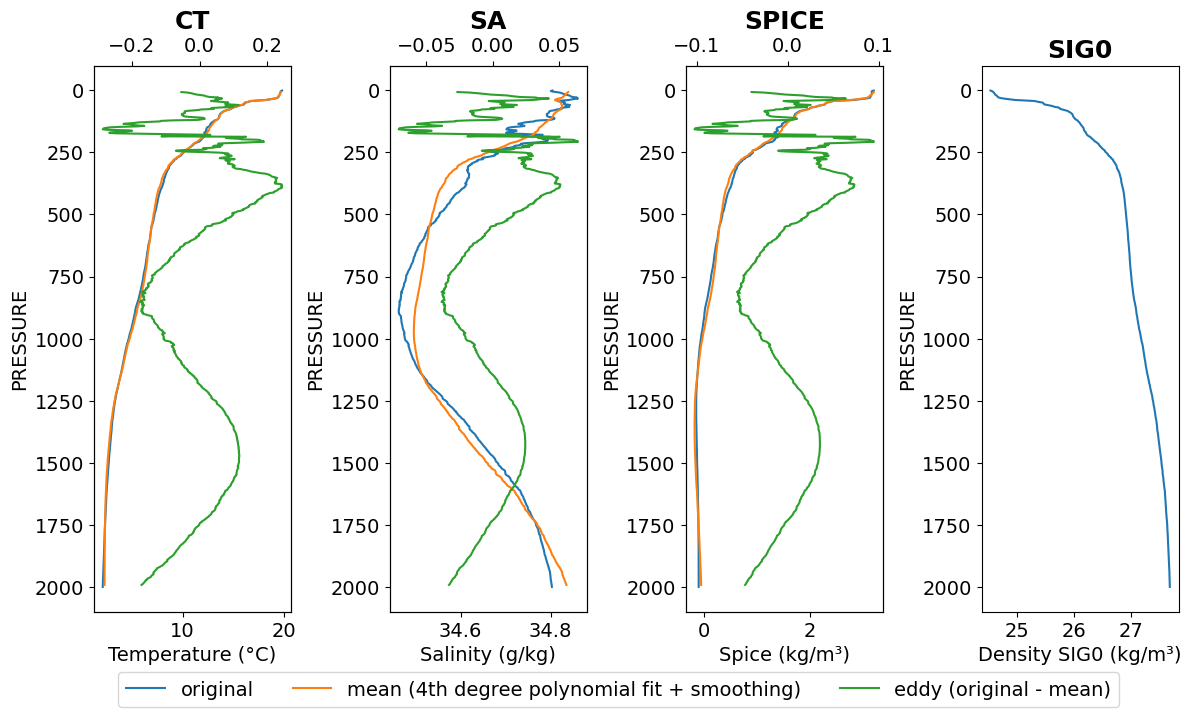

In [33]:
plt.figure(figsize=(14,7))
prof = section_p.isel(PROFILE=1)

plt.subplot(141)
prof.CT.plot(y='PRESSURE', label='original')
prof.CT_m.plot(y='PRESSURE', label='mean (4th degree polynomial fit + smoothing)')
plt.xlabel('Temperature (°C)')
plt.title('')
plt.twiny()
prof.CT_e.plot(y='PRESSURE',color='tab:green', label='eddy (original - mean)')
plt.xlabel('')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(142)
prof.SA.plot(y='PRESSURE')
prof.SA_m.plot(y='PRESSURE')
plt.xlabel('Salinity (g/kg)')
plt.title('')
plt.twiny()
prof.SA_e.plot(y='PRESSURE',color='tab:green')
plt.xlabel('')
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(143)
prof.SPICE.plot(y='PRESSURE')
prof.SPICE_m.plot(y='PRESSURE')
plt.xlabel('Spice (kg/m³)')
plt.title('')
plt.twiny()
prof.SPICE_e.plot(y='PRESSURE',color='tab:green')
plt.xlabel('')
plt.gca().invert_yaxis()
plt.title('SPICE')

plt.subplot(144)
prof.SIG0.plot(y='PRESSURE')
plt.xlabel('Density SIG0 (kg/m³)')
plt.gca().invert_yaxis()
plt.title('SIG0')

plt.subplots_adjust(wspace=0.5, bottom=0.1)
plt.figlegend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3);

Polynomial fit performed on entire profiles


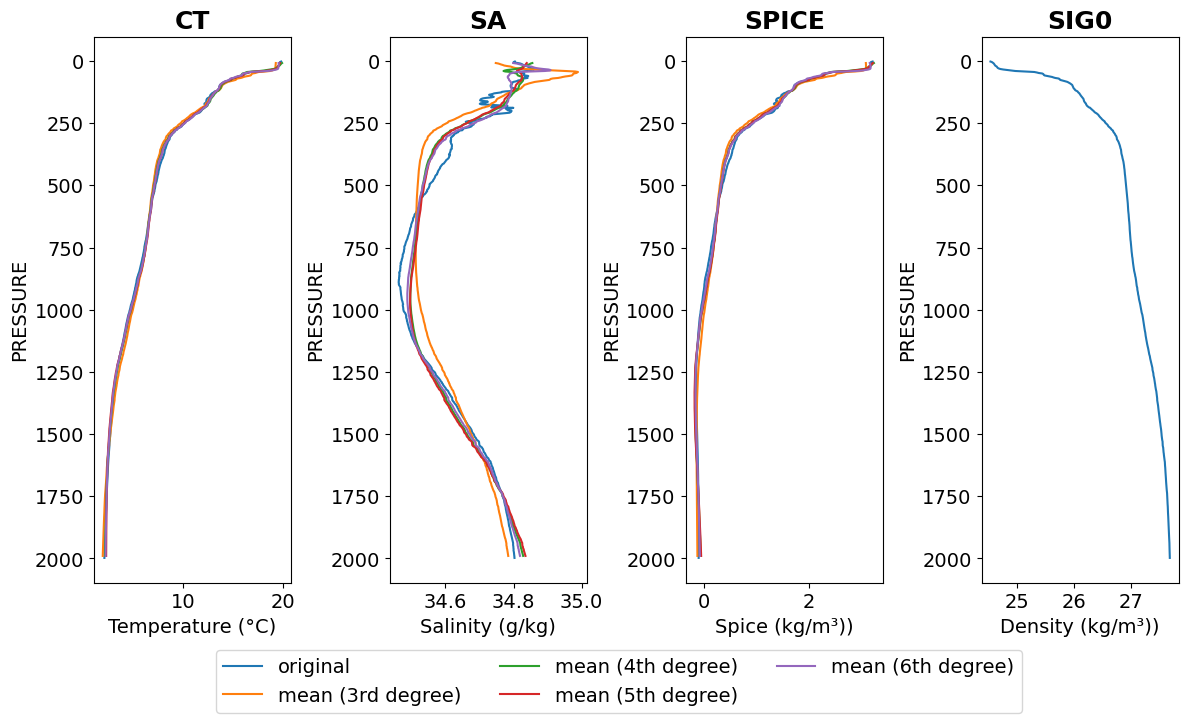

In [53]:
plt.figure(figsize=(14,7))
prof = 1

plt.subplot(141)
section_p.isel(PROFILE=prof).CT.plot(y='PRESSURE', label='original')
section_3.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (3rd degree)')
section_4.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (4th degree)')
section_5.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (5th degree)')
section_6.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (6th degree)')
plt.xlabel('Temperature (°C)')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(142)
section_p.isel(PROFILE=prof).SA.plot(y='PRESSURE')
section_3.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
section_4.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
section_5.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
section_6.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
plt.xlabel('Salinity (g/kg)')
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(143)
section_p.isel(PROFILE=prof).SPICE.plot(y='PRESSURE')
section_3.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
section_4.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
section_5.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
section_6.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
plt.xlabel('Spice (kg/m³))')
plt.gca().invert_yaxis()
plt.title('SPICE')

plt.subplot(144)
section_p.isel(PROFILE=prof).SIG0.plot(y='PRESSURE')
plt.xlabel('Density (kg/m³))')
plt.gca().invert_yaxis()
plt.title('SIG0')

plt.subplots_adjust(wspace=0.5, bottom=0.1)
plt.figlegend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
print('Polynomial fit performed on entire profiles')

Polynomial fit performed on profile slices between 375-1850 dbar


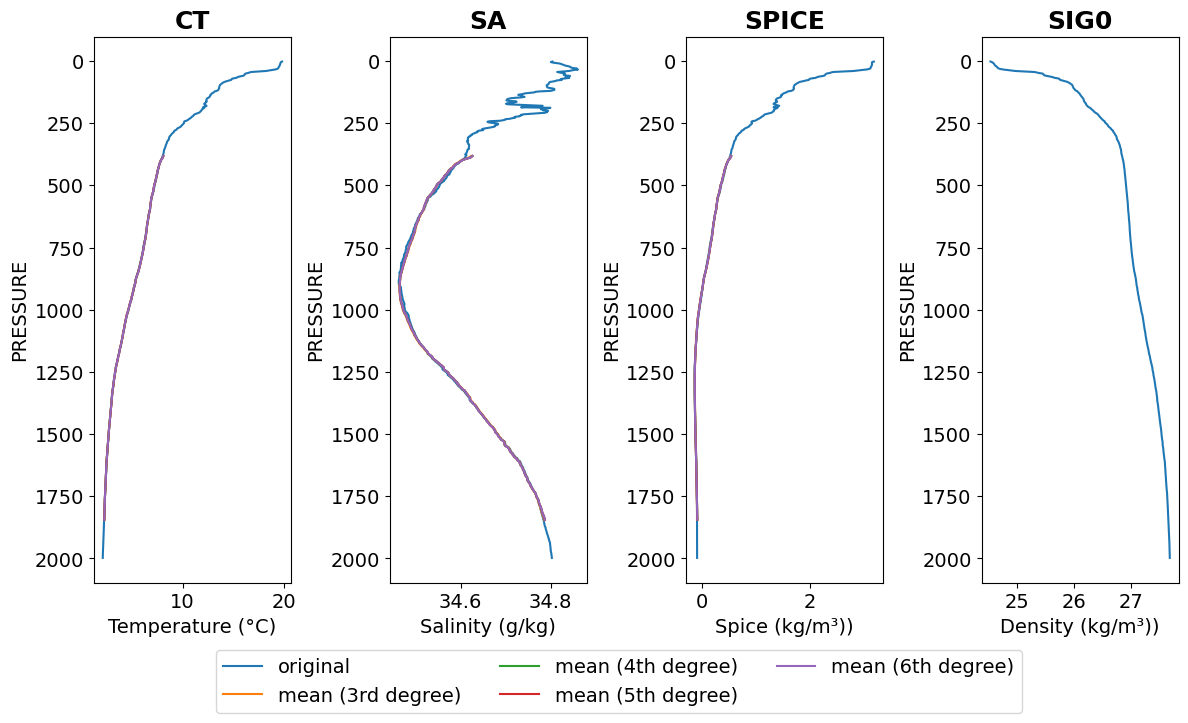

In [54]:
plt.figure(figsize=(14,7))
prof = 1

plt.subplot(141)
section_p.isel(PROFILE=prof).CT.plot(y='PRESSURE', label='original')
section_3_slice.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (3rd degree)')
section_4_slice.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (4th degree)')
section_5_slice.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (5th degree)')
section_6_slice.isel(PROFILE=prof).CT_m.plot(y='PRESSURE', label='mean (6th degree)')
plt.xlabel('Temperature (°C)')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(142)
section_p.isel(PROFILE=prof).SA.plot(y='PRESSURE')
section_3_slice.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
section_4_slice.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
section_5_slice.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
section_6_slice.isel(PROFILE=prof).SA_m.plot(y='PRESSURE')
plt.xlabel('Salinity (g/kg)')
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(143)
section_p.isel(PROFILE=prof).SPICE.plot(y='PRESSURE')
section_3_slice.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
section_4_slice.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
section_5_slice.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
section_6_slice.isel(PROFILE=prof).SPICE_m.plot(y='PRESSURE')
plt.xlabel('Spice (kg/m³))')
plt.gca().invert_yaxis()
plt.title('SPICE')

plt.subplot(144)
section_p.isel(PROFILE=prof).SIG0.plot(y='PRESSURE')
plt.xlabel('Density (kg/m³))')
plt.gca().invert_yaxis()
plt.title('SIG0')

plt.subplots_adjust(wspace=0.5, bottom=0.1)
plt.figlegend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3);
print('Polynomial fit performed on profile slices between 375-1850 dbar')

In [42]:
K_rho_p = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc').K.drop_vars(['z_l','z_r','lon_l','lon_r','lat_l','lat_r'])
K_rho_p = K_rho_p.rename({'z_c':'PRESSURE', 'lat_c':'LAT', 'lon_c':'LON'})

In [45]:
K_rho_sel_p = K_rho_p.sel(LON=section_p.LON.mean(), LAT=section_p.LAT.mean(), method='nearest')
K_rho_sel_p = K_rho_sel_p.interp(PRESSURE=section_p.PRESSURE)

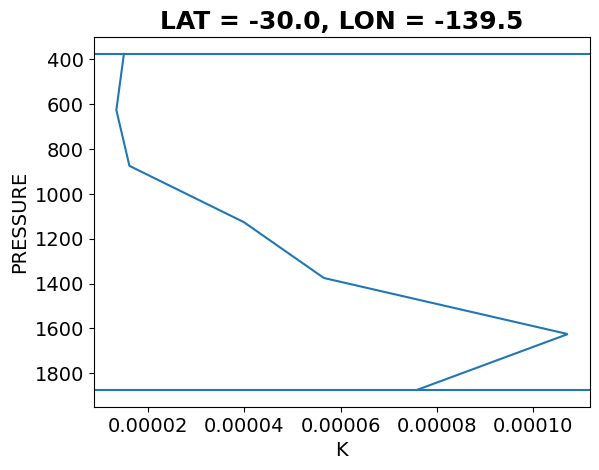

In [47]:
K_rho_sel_p.plot(y='PRESSURE')
plt.gca().invert_yaxis()
plt.axhline(375)
plt.axhline(1875)

### whole profile

In [55]:
ct_e_z2 = section_p.CT_e.differentiate(coord='PRESSURE')**2
sa_e_z2 = section_p.SA_e.differentiate(coord='PRESSURE')**2
sp_e_z2 = section_p.SPICE_e.differentiate(coord='PRESSURE')**2

In [56]:
lfilt=100
ct_e_z2_filt = ff.da_filt_single(ct_e_z2, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sa_e_z2_filt = ff.da_filt_single(sa_e_z2, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sp_e_z2_filt = ff.da_filt_single(sp_e_z2, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})

In [57]:
ct2_VPR = K_rho_sel_p*ct_e_z2_filt
sa2_VPR = K_rho_sel_p*sa_e_z2_filt
sp2_VPR = K_rho_sel_p*sp_e_z2_filt

In [58]:
ct_m_z2 = section_p.CT_m.differentiate(coord='PRESSURE')**2
sa_m_z2 = section_p.SA_m.differentiate(coord='PRESSURE')**2
sp_m_z2 = section_p.SPICE_m.differentiate(coord='PRESSURE')**2

In [59]:
ct_m_z2_filt = ff.da_filt_single(ct_m_z2, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sa_m_z2_filt = ff.da_filt_single(sa_m_z2, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sp_m_z2_filt = ff.da_filt_single(sp_m_z2, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})

In [60]:
ct3_VPR = K_rho_sel_p*ct_m_z2_filt
sa3_VPR = K_rho_sel_p*sa_m_z2_filt
sp3_VPR = K_rho_sel_p*sp_m_z2_filt

In [61]:
ct_meso_frac = ct2_VPR / (ct2_VPR + ct3_VPR)
sa_meso_frac = sa2_VPR / (sa2_VPR + sa3_VPR)
sp_meso_frac = sp2_VPR / (sp2_VPR + sp3_VPR)

### Slice

In [62]:
ct_e_z2_slice = section_4_slice.CT_e.differentiate(coord='PRESSURE')**2
sa_e_z2_slice = section_4_slice.SA_e.differentiate(coord='PRESSURE')**2
sp_e_z2_slice = section_4_slice.SPICE_e.differentiate(coord='PRESSURE')**2

In [63]:
lfilt=100
ct_e_z2_filt_slice = ff.da_filt_single(ct_e_z2_slice, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sa_e_z2_filt_slice = ff.da_filt_single(sa_e_z2_slice, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sp_e_z2_filt_slice = ff.da_filt_single(sp_e_z2_slice, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})

In [64]:
ct2_VPR_slice = K_rho_sel_p*ct_e_z2_filt_slice
sa2_VPR_slice = K_rho_sel_p*sa_e_z2_filt_slice
sp2_VPR_slice = K_rho_sel_p*sp_e_z2_filt_slice

In [65]:
ct_m_z2_slice = section_3_slice.CT_m.differentiate(coord='PRESSURE')**2
sa_m_z2_slice = section_3_slice.SA_m.differentiate(coord='PRESSURE')**2
sp_m_z2_slice = section_3_slice.SPICE_m.differentiate(coord='PRESSURE')**2

In [66]:
ct_m_z2_filt_slice = ff.da_filt_single(ct_m_z2_slice, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sa_m_z2_filt_slice = ff.da_filt_single(sa_m_z2_slice, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})
sp_m_z2_filt_slice = ff.da_filt_single(sp_m_z2_slice, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT','lon':'LON'})

In [67]:
ct3_VPR_slice = K_rho_sel_p*ct_m_z2_filt_slice
sa3_VPR_slice = K_rho_sel_p*sa_m_z2_filt_slice
sp3_VPR_slice = K_rho_sel_p*sp_m_z2_filt_slice

In [68]:
ct_meso_frac_slice = ct2_VPR_slice / (ct2_VPR_slice + ct3_VPR_slice)
sa_meso_frac_slice = sa2_VPR_slice / (sa2_VPR_slice + sa3_VPR_slice)
sp_meso_frac_slice = sp2_VPR_slice / (sp2_VPR_slice + sp3_VPR_slice)

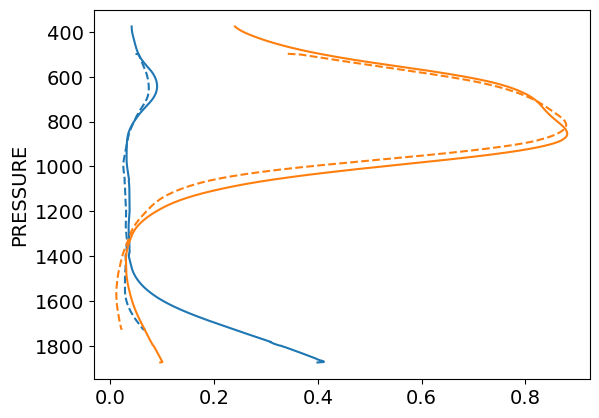

In [73]:
ct_meso_frac.mean('PROFILE').plot(y='PRESSURE',color='tab:blue')
ct_meso_frac_slice.mean('PROFILE').plot(y='PRESSURE',color='tab:blue',linestyle='--')
sa_meso_frac.mean('PROFILE').plot(y='PRESSURE',color='tab:orange')
sa_meso_frac_slice.mean('PROFILE').plot(y='PRESSURE',color='tab:orange',linestyle='--')
plt.gca().invert_yaxis()

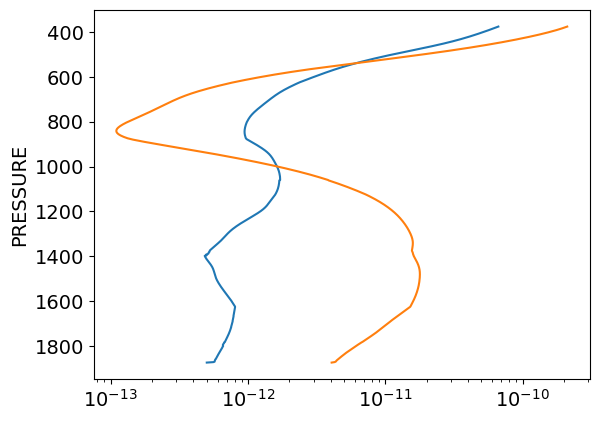

In [70]:
sa2_VPR.mean('PROFILE').plot(y='PRESSURE')
sa3_VPR.mean('PROFILE').plot(y='PRESSURE')
plt.gca().invert_yaxis()
plt.xscale('log')

In [ ]:
ct2_VPR.to_netcdf('/swot/SUM05/amf2288/box_ct2_VPR.nc')
ct3_VPR.to_netcdf('/swot/SUM05/amf2288/box_ct3_VPR.nc')

sa2_VPR.to_netcdf('/swot/SUM05/amf2288/box_sa2_VPR.nc')
sa3_VPR.to_netcdf('/swot/SUM05/amf2288/box_sa3_VPR.nc')

sp2_VPR.to_netcdf('/swot/SUM05/amf2288/box_sp2_VPR.nc')
sp3_VPR.to_netcdf('/swot/SUM05/amf2288/box_sp3_VPR.nc')